# Forecasting Air Temperature in California

* [Introduction](#1) 
* [Importing libraries](#2)
* [Connecting to your GIS](#3)
* [Accessing & visualizing the dataset](#4) 
* [Time series data preprocessing](#5) 
    * [Converting into time series format ](#6)
    * [Datatype of time series variables ](#7)
    * [Checking autocorrelation of time dependent variables ](#8)
    * [Creating dataset for prediction ](#9)
    * [Train - Test split of time series dataset ](#10)       
* [Time series model building](#11)
    * [Data preprocessing ](#12)  
    * [Model initialization ](#13)
    * [Learning rate search ](#14)
    * [Model training ](#15) 
* [Air temperature forecast & validation](#16)   
    * [Forecasting Using the trained TimeSeriesModel ](#17)
    * [Estimate model metrics for validation ](#18)
    * [Result visualization ](#19)
* [Conclusion](#20)
* [Summary of methods used](#21)
* [References](#22)
* [Data resources](#23)

## Introduction <a class="anchor" id="1"></a>

The rise in air temperature is directly correlated with Global warming and change in climatic conditions. Air temperature is one of the main factors in predicting other meteorological variables like streamflow, evapotranspiration and solar radiation. Hence accurate forecasting of this variable is prime to mitigate environmental and economic destruction. Including the dependency of air temperature in other variables like wind speed, precipitation, etc. is helping in more precise prediction. In this study, the deep learning TimeSeriesModel from arcgis.learn is used to predict monthly air temperature for two years at a ground station in the Fresno Yosemite International Airport, California, USA. The dataset ranges from 1948-2015. Data from January 2014 to November 2015 is used to validate the quality of the forecast.

Univariate time series modeling is one of the popular applications of time series analysis. This study includes multivariate time series analysis which is a bit more convoluted i.e. dataset contains more than one time-dependent variable. The TimeSeriesModel from arcgis.learn includes backbones such as InceptionTime, ResCNN, Resnet and FCN which does not need fine-tuning of multiple hyperparameters before fitting the model. Here is the schematic flow chart of the methodology:

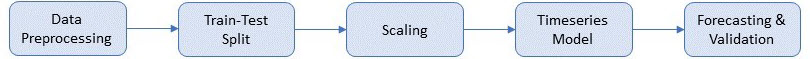

## Importing libraries <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as aplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## Connecting to your GIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS("home")

## Accessing & visualizing the dataset <a class="anchor" id="4"></a>

The data used in this sample study is a multivariate time series dataset at a monthly time scale from a fixed location in the state of California. The temporal range of the dataset is from January 1948 to November 2015.

In [3]:
# Location of the ground station
location = gis.map(location="Fresno Yosemite International California", zoomlevel=12)
location

MapView(layout=Layout(height='400px', width='100%'))

<Item title:"Weather Data of Fresno International California" type:Feature Layer Collection owner:api_data_owner>
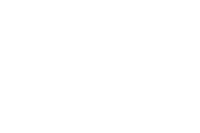

In [4]:
# Access the data table
data_table = gis.content.get("8c58e808aabd40408f7bc4eeac64fffb")
data_table

In [5]:
climate_data = data_table.tables[0]

In [6]:
# Visualize as pandas dataframe
climate_df = climate_data.query().sdf

In [7]:
climate_df.head()

,STATION,NAME,DATE,AWND,PRCP,PSUN,SNOW,TAVG,TMAX,TMIN,TSUN,WSFG,ObjectId
0,USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",1948-01-01,None,0.00,None,0,51.2,66.3,36.2,None,None,1
1,USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",1948-02-01,None,0.78,None,0,49.0,62.2,35.8,None,None,2
2,USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",1948-03-01,None,2.29,None,0,53.2,65.6,40.7,None,None,3
3,USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",1948-04-01,None,2.28,None,0,59.8,71.8,47.7,None,None,4
4,USW00093193,"FRESNO YOSEMITE INTERNATIONAL, CA US",1948-05-01,None,0.96,None,0,65.2,79.7,50.7,None,None,5


In [8]:
climate_df.shape

(815, 13)

Next, the dataset is prepared wherein the variables/columns such as station, possible sunshine, snow cover, total sunshine, and peak wind gust speed are dropped. These variables do not directly affect air temperature. And, to get a continuous dataset without NaN values, the dataset is chosen from the year 1987 onwards.

In [9]:
climate_df.columns

Index(['STATION', 'NAME', 'DATE', 'AWND', 'PRCP', 'PSUN', 'SNOW', 'TAVG',
       'TMAX', 'TMIN', 'TSUN', 'WSFG', 'ObjectId'],
      dtype='object')

In [10]:
climate_df = climate_df.drop(
    ["ObjectId", "STATION", "NAME", "PSUN", "SNOW", "TSUN", "WSFG"], axis=1
)

In [11]:
# Selecting dataset from year 1987 to get continous data without NAN values
selected_df = climate_df[climate_df.DATE > "1987"]
selected_df.head()

,DATE,AWND,PRCP,TAVG,TMAX,TMIN
469,1987-02-01,5.8,1.36,52.7,63.2,42.2
470,1987-03-01,6.3,2.39,55.6,66.4,44.8
471,1987-04-01,6.9,0.07,66.6,82.3,51.0
472,1987-05-01,7.4,0.87,71.8,86.1,57.5
473,1987-06-01,7.4,0.01,78.4,94.4,62.4


In [12]:
selected_df.shape

(346, 6)

## Time series data preprocessing<a class="anchor" id="5"></a>   
The preprocessing of the data for multivariate time series modeling includes the following steps:

### Converting into time series format<a class="anchor" id="6"></a>
The dataset is now transformed into a time series data format by creating a new index that is to be used by the model for processing the sequential data.

In [13]:
final_df = selected_df.reset_index()
final_df = final_df.drop("index", axis=1)
final_df.head()

,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,1987-02-01,5.8,1.36,52.7,63.2,42.2
1,1987-03-01,6.3,2.39,55.6,66.4,44.8
2,1987-04-01,6.9,0.07,66.6,82.3,51.0
3,1987-05-01,7.4,0.87,71.8,86.1,57.5
4,1987-06-01,7.4,0.01,78.4,94.4,62.4


###  Datatype of time series variables<a class="anchor" id="7"></a> 
Checking the data type of the variables.

In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    346 non-null    datetime64[ns]
 1   AWND    346 non-null    object        
 2   PRCP    346 non-null    float64       
 3   TAVG    346 non-null    float64       
 4   TMAX    346 non-null    float64       
 5   TMIN    346 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 16.3+ KB


The time-dependent variables should be in float. If the variable is not of a float data type, then it needs to be changed to float. Here, Windspeed (AWND) is converted from object dtype to float64 as shown in the next cell.

In [15]:
final_df["AWND"] = final_df["AWND"].astype("float64")
final_df.head()

,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,1987-02-01,5.8,1.36,52.7,63.2,42.2
1,1987-03-01,6.3,2.39,55.6,66.4,44.8
2,1987-04-01,6.9,0.07,66.6,82.3,51.0
3,1987-05-01,7.4,0.87,71.8,86.1,57.5
4,1987-06-01,7.4,0.01,78.4,94.4,62.4


### Checking autocorrelation of time dependent variables<a class="anchor" id="8"></a> 
This step is to determine if the time series sequence is autocorrelated. To ensure that our time series data can be modeled well, the strength of correlation of the variable with its past data must be estimated.

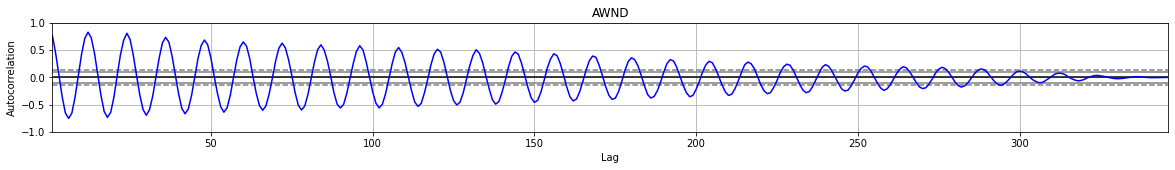

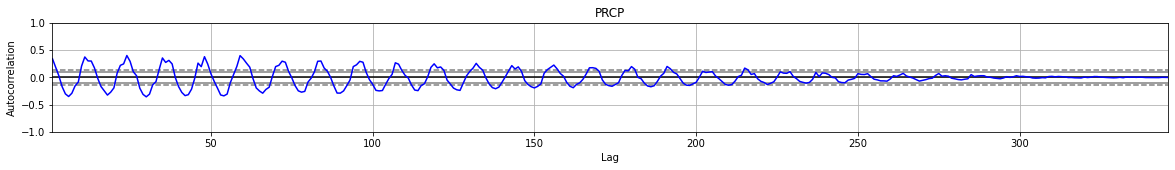

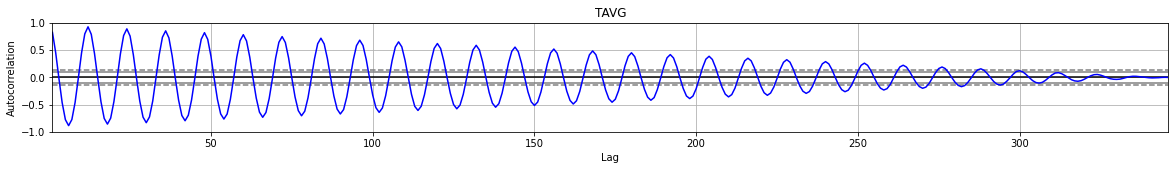

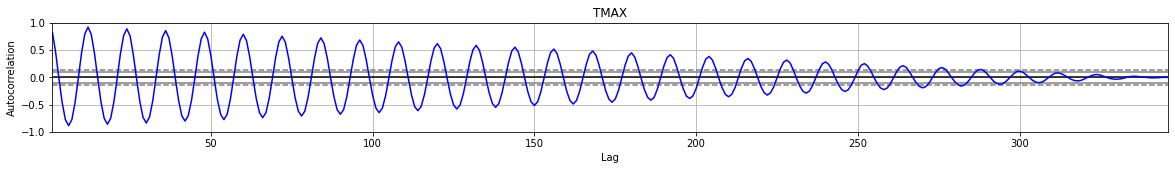

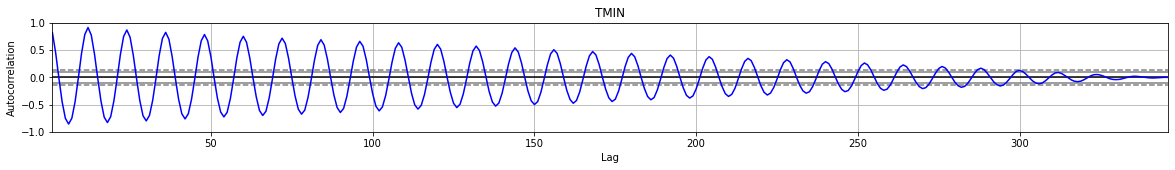

In [16]:
variables = ["AWND", "PRCP", "TAVG", "TMAX", "TMIN"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(final_df[variable], color="blue")
    plt.title(variable)

The plots are showing a significant correlation of the data with its immediate time-lagged terms, and that it gradually decreases over time as the lag increases.

### Creating dataset for prediction<a class="anchor" id="9"></a> 
Here a copy of the dataset is taken and for 2014-2015 the predicted variable column is replaced with NaN. This format is required for the `model.predict()` function in multivariate time series analysis.

In [17]:
predict_df = final_df.copy()
predict_df.loc[predict_df["DATE"] > "2013-12-01", "TAVG"] = None

### Train - Test split of time series dataset<a class="anchor" id="10"></a> 
Out of these 27 years(1987-2015), 25 years of data is used for training the model and the 2 years (2014-2015) or a total of 23 months of data is used for forecasting and validation. 

Splitting timeseries data by keeping shuffle=False to keep the sequence intact, and test size of 12 months for validation.

In [18]:
test_size = 23
train, test = train_test_split(final_df, test_size=test_size, shuffle=False)

In [19]:
train

,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,1987-02-01,5.8,1.36,52.7,63.2,42.2
1,1987-03-01,6.3,2.39,55.6,66.4,44.8
2,1987-04-01,6.9,0.07,66.6,82.3,51.0
3,1987-05-01,7.4,0.87,71.8,86.1,57.5
4,1987-06-01,7.4,0.01,78.4,94.4,62.4
...,...,...,...,...,...,...
318,2013-08-01,7.2,0.00,83.0,98.3,67.7
319,2013-09-01,6.5,0.01,77.8,91.5,64.2
320,2013-10-01,3.4,0.03,66.6,80.3,52.9
321,2013-11-01,2.5,0.54,58.5,70.5,46.4


## Time series model building<a class="anchor" id="11"></a> 
After the train and test sets are created, the training set is ready for modeling.

### Data preprocessing <a class="anchor" id="12"></a>

In this example, the dataset contains 'AWND' (Windspeed), 'PRCP' (Precipitation), 'TAVG' (Average Air temperature), 'TMAX' (Maximum Airtemperature), and 'TMIN' (Minimum Airtemperature) as time-dependent variables leading to multivariate time series analysis at monthly time scale. These variables are used to forecast the next 23 months of air temperature for the months after the last date in the training data, or, these multiple explanatory variables are used to predict the future values of the air temperature.

Once the variables are identified, the preprocessing of the data is performed by the `prepare_tabulardata` method from the `arcgis.learn` module in the ArcGIS API for Python. This function takes either a non-spatial data frame, a feature layer, or a spatial data frame containing the dataset as input, and returns a TabularDataObject that can be fed into the model. By default, `prepare_tabulardata` scales/normalizes the numerical columns in dataset using  StandardScaler.

The primary input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : non spatial dataframe, feature layer, or spatial dataframe containing the primary dataset and the explanatory variables, if there are any
- <span style='background :lightgrey' >variable_predict</span> : field name containing the y-variable to be forecasted from the input feature layer/dataframe
- <span style='background :lightgrey' >explanatory_variables</span> : list of the field names as 2-sized tuples containing the explanatory variables as mentioned above. Since there are none in this example, it is not required here 
- <span style='background :lightgrey' >index_field</span> : field name containing the timestamp

In [20]:
data = prepare_tabulardata(
    train,
    variable_predict="TAVG",
    explanatory_variables=["AWND", "PRCP", "TMAX", "TMIN"],
    index_field="DATE",
    seed=42,
)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:936: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



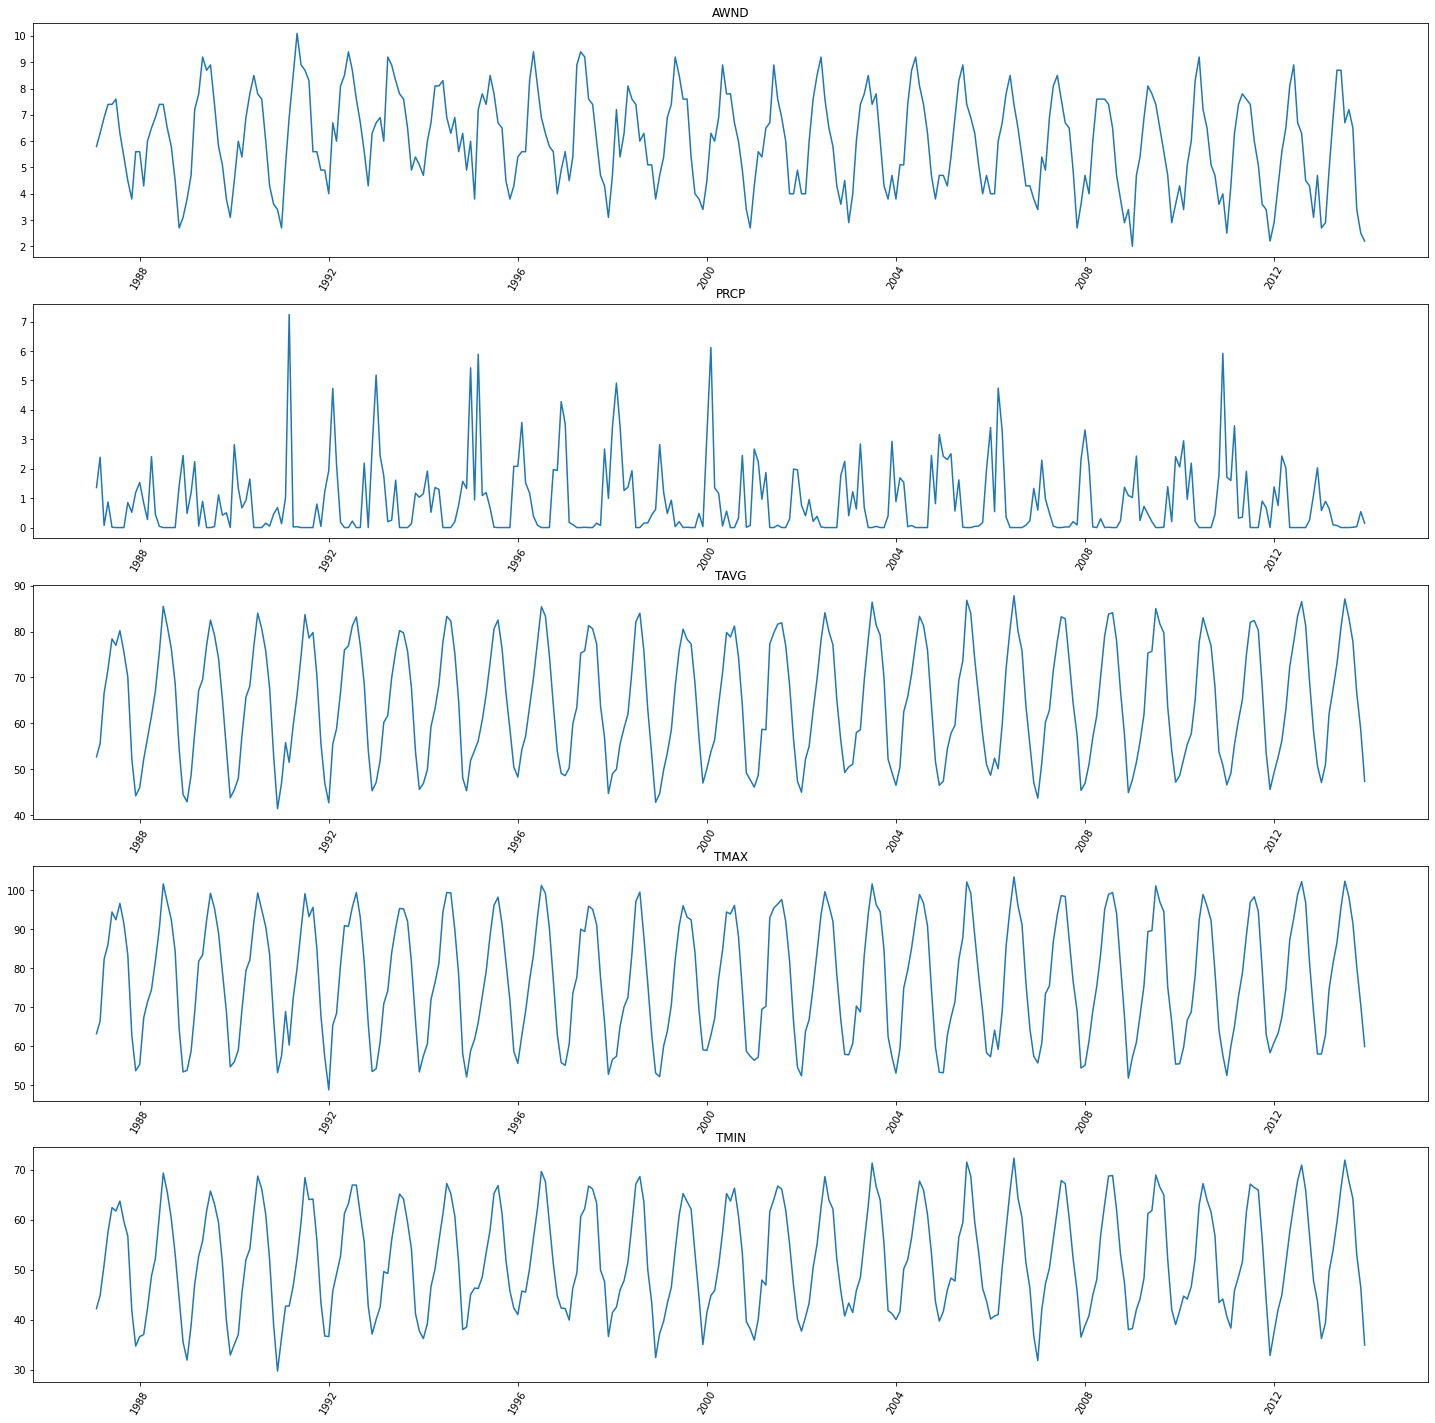

In [21]:
# Visualize the entire timeseries data
data.show_batch(graph=True)

In [22]:
# Here sequence length is used as 12 which also indicates the seasonality of the data
seq_len = 12

Visualize the timeseries in batches, here the sequence length is mentioned which would be treated as the batch length

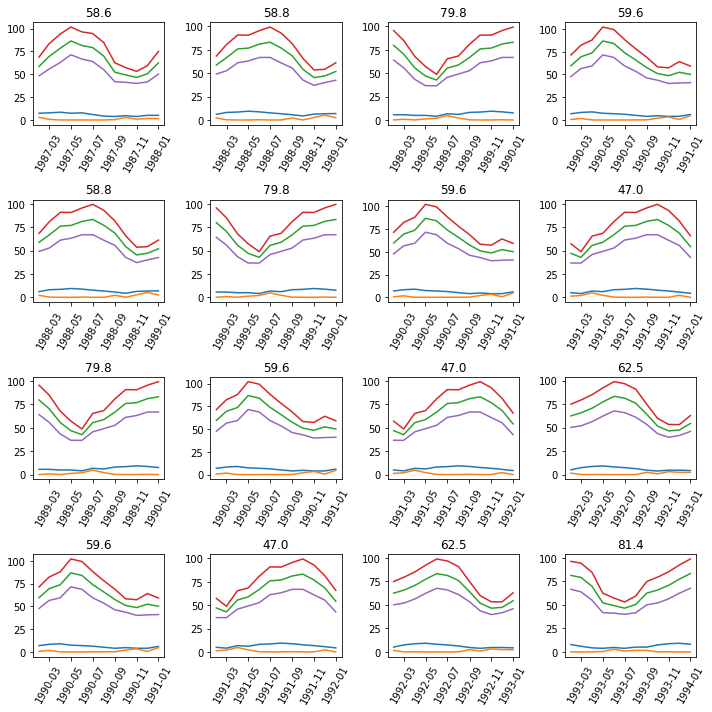

In [23]:
data.show_batch(rows=4, seq_len=seq_len)

### Model initialization <a class="anchor" id="13"></a>

This is the important step for fitting a time series model. Here, along with the input dataset, the backbone for training the model and the sequence length is passed as parameters. Out of these three, the sequence length has to be selected carefully. The sequence length is usually the cycle of the data, which in this case is 12, as it is monthly data and the pattern repeats after 12 months.  In model initialization, the data and the backbone is selected from the available set of InceptionTime, ResCNN, Resnet, and FCN.

In [24]:
tsmodel = TimeSeriesModel(data, seq_len=seq_len, model_arch="ResCNN")

### Learning rate search<a class="anchor" id="14"></a>
Finding the learning rate for training the model

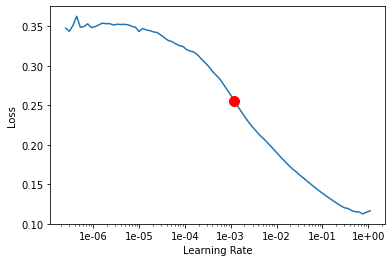

In [25]:
lr_rate = tsmodel.lr_find()

### Model training <a class="anchor" id="15"></a>

The model is now ready for training. To train the model, the `model.fit` method is used and is provided with the number of epochs for training and the estimated learning rate suggested by `lr_find` in the previous step:

In [26]:
tsmodel.fit(100, lr=lr_rate)

epoch,train_loss,valid_loss,time
0,0.320048,0.325258,00:00
1,0.296921,0.306485,00:00
2,0.280180,0.310841,00:00
3,0.260043,0.339595,00:00
4,0.242494,0.363511,00:00
5,0.222688,0.338755,00:00
6,0.201958,0.278246,00:00
7,0.181193,0.214388,00:00
8,0.160230,0.152751,00:00
9,0.140364,0.082313,00:00


To check the quality of the trained model or whether the model needs more training, train vs valid loss plot is shown below

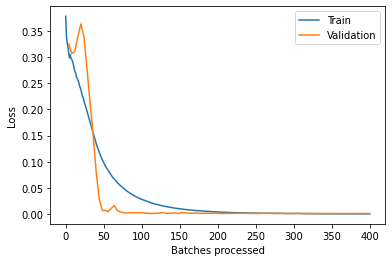

In [27]:
tsmodel.plot_losses()

The predicted values by the trained model is printed for the test set.

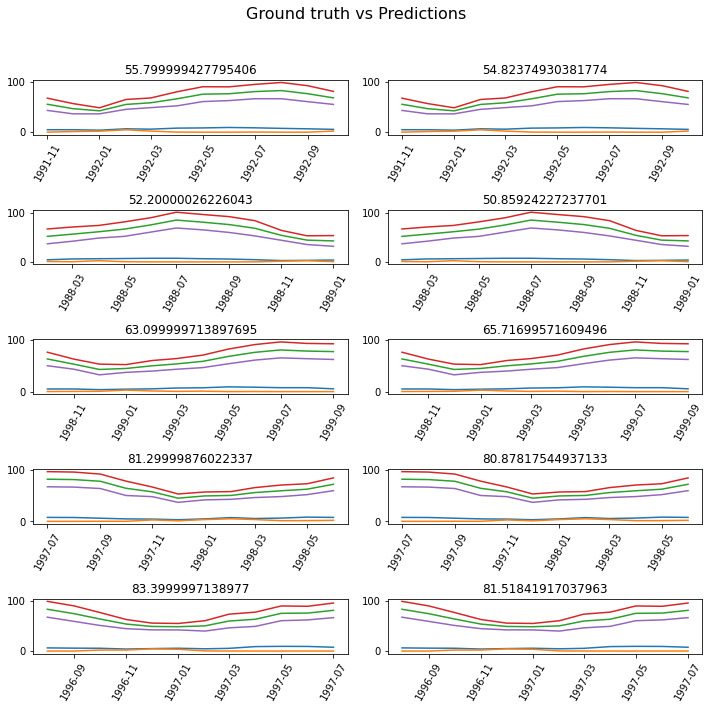

In [28]:
tsmodel.show_results(rows=5)

## Air temperature forecast & validation <a class="anchor" id="16"></a>

### Forecasting using the trained TimeSeriesModel <a class="anchor" id="17"></a>
During forecasting, the model uses dataset prepared above with NaN values for predicting variable as input and `prediction_type` is given as dataframe.

In [29]:
# Checking the input dataset
predict_df.tail(23)

,DATE,AWND,PRCP,TAVG,TMAX,TMIN
323,2014-01-01,2.5,0.57,NaN,66.8,39.5
324,2014-02-01,4.9,2.11,NaN,66.7,46.8
325,2014-03-01,5.8,0.62,NaN,74.3,50.4
326,2014-04-01,6.9,0.74,NaN,80.0,53.6
327,2014-05-01,8.9,0.04,NaN,88.3,60.2
328,2014-06-01,8.1,0.00,NaN,96.4,65.5
329,2014-07-01,7.4,0.01,NaN,101.2,72.6
330,2014-08-01,6.7,0.00,NaN,98.6,70.1
331,2014-09-01,6.3,0.18,NaN,94.6,66.9
332,2014-10-01,4.5,0.50,NaN,85.7,58.3


In [30]:
df_forecasted = tsmodel.predict(predict_df, prediction_type="dataframe")

In [31]:
# Final forecasted result returned by the model
df_forecasted

,DATE,AWND,PRCP,TAVG,TMAX,TMIN,TAVG_results
0,1987-02-01,5.8,1.36,52.7,63.2,42.2,52.700000
1,1987-03-01,6.3,2.39,55.6,66.4,44.8,55.600000
2,1987-04-01,6.9,0.07,66.6,82.3,51.0,66.600000
3,1987-05-01,7.4,0.87,71.8,86.1,57.5,71.800000
4,1987-06-01,7.4,0.01,78.4,94.4,62.4,78.400000
...,...,...,...,...,...,...,...
341,2015-07-01,8.1,0.43,NaN,96.8,69.3,82.851526
342,2015-08-01,7.6,0.00,NaN,97.1,67.7,81.900514
343,2015-09-01,5.8,0.12,NaN,92.4,65.0,76.308616
344,2015-10-01,4.7,0.49,NaN,83.1,59.4,67.859790


Formating the result into actual vs the predicted columns

In [32]:
result_df = pd.DataFrame()
result_df["DATE"] = test["DATE"]
result_df["Airtemp_actual"] = test["TAVG"]
result_df["Airtemp_predicted"] = df_forecasted["TAVG_results"][-23:]
result_df = result_df.set_index(result_df.columns[0])
result_df

,Airtemp_actual,Airtemp_predicted
DATE,,
2014-01-01,53.2,46.677155
2014-02-01,56.8,50.891665
2014-03-01,62.3,60.275957
2014-04-01,66.8,64.774662
2014-05-01,74.2,70.682119
2014-06-01,80.9,78.123859
2014-07-01,86.9,84.795002
2014-08-01,84.4,81.264308
2014-09-01,80.7,75.548116


### Estimate model metrics for validation <a class="anchor" id="18"></a>
The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values for 23 months.

In [33]:
r2 = r2_score(result_df["Airtemp_actual"], result_df["Airtemp_predicted"])
mse = metrics.mean_squared_error(
    result_df["Airtemp_actual"], result_df["Airtemp_predicted"]
)
rmse = metrics.mean_absolute_error(
    result_df["Airtemp_actual"], result_df["Airtemp_predicted"]
)
print(
    "RMSE:     ",
    round(np.sqrt(mse), 4),
    "\n" "MAE:      ",
    round(rmse, 4),
    "\n" "R-Square: ",
    round(r2, 2),
)

RMSE:      4.0035 
MAE:       3.4705 
R-Square:  0.89


A considerably high r-square value indicates a high similarity between the forecasted and the actual values. And, RMSE error is quite low showing good fit by model.

## Result visualization<a class="anchor" id="19"></a>
Finally, the actual and forecasted values are plotted to visualize their distribution over the validation period, with the blue lines indicating forecasted values and the orange line showing the actual values.

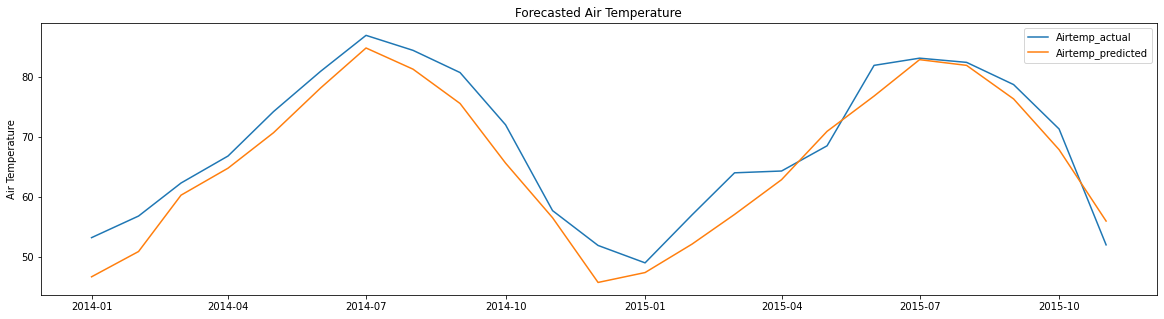

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(result_df)
plt.ylabel("Air Temperature")
plt.legend(result_df.columns.values, loc="upper right")
plt.title("Forecasted Air Temperature")
plt.show()

## Conclusion<a class="anchor" id="20"></a>

The study conducted multivariate time series analysis using Deep learning TimeSeriesModel from the arcgis.learn and forecasted monthly Airtemperature for a station in California. The model was trained with 25 years (1987-2013) of data and forecasted for a period of 2 years (2014-2015) with high accuracy. The other dependent variables were wind speed, precipitation, minimum temperature, and maximum temperature. The methodology included preparing a times series dataset using the prepare_tabulardata() method, followed by modeling, predicting, and then validating the test dataset. Usually, time series modeling requires fine-tuning several hyperparameters for properly fitting the data, most of which has been internalized in this Model, leaving the user responsible for configuring only a few significant parameters, like the sequence length.

## Summary of methods used <a class="anchor" id="21"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, scaling and train-test split  |prepare data ready for fitting a  Timeseries Model 
| model.lr_find()| finds an optimal learning rate  | finalize a good learning rate for training the Timeseries model
| TimeSeriesModel() | Model Initialization by selecting the TimeSeriesModel algorithm to be used for fitting  | Selected Timeseries algorithm from Fastai time series regression can be used
| model.fit() | trains a model with epochs & learning rate as input  | training the Timeseries model with suitable input 
| model.predict() | predicts on a test set | forecast values using the trained models on the test input

## References<a class="anchor" id="22"></a>
- Jenny Cifuentes et.al., 2020. "Air Temperature Forecasting Using Machine Learning Techniques: A Review" 
https://doi.org/10.3390/en13164215

- Xuejie, G. et.al., 2001. "Climate change due to greenhouse effects in China as simulated by a regional climate model" https://doi.org/10.1007/s00376-001-0036-y

- "gsom-gsoy_documentation" https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/gsom-gsoy_documentation.pdf

- "Prediction task with Multivariate Time Series and VAR model" https://towardsdatascience.com/prediction-task-with-multivariate-timeseries-and-var-model-47003f629f9

## Data resources <a class="anchor" id="23"></a>

| Dataset | Source | Link |
| -| - |-|
|Global Summary of the Month|NOAA Climate Data Online |https://www.ncdc.noaa.gov/cdo-web/search|